In [1]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.4 MB 5.6 MB/s eta 0:00:03
   ---- ----------------------------------- 1.8/16.4 MB 4.6 MB/s eta 0:00:04
   ------ --------------------------------- 2.6/16.4 MB 4.3 MB/s eta 0:00:04
   -------- ------------------------------- 3.7/16.4 MB 4.2 MB/s eta 0:00:04
   ---------- ----------------------------- 4.5/16.4 MB 4.1 MB/s eta 0:00:03
   ------------ --------------------------- 5.2/16.4 MB 4.1 MB/s eta 0:00:03
   -------------- ------------------------- 6.0/16.4 MB 4.1 MB/s eta 0:00:03
   ---------------- ----------------------- 6.8/16.4 MB 4.1 MB/s eta 0:00:03
   ------------------ --------------------- 7.6/16.4 MB 4.1 MB/s eta 0:00:03
   -------------------- ------------------- 8.4/16.4 MB 4.1 MB/s eta 0:00:02
   ---------------------- ----------------- 9.2/16.4 MB 4.0 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.4 MB 4.0 MB/s eta 0:00:02
   --

In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='huzaifa2003',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/data_project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector
import numpy as np

In [2]:
db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "huzaifa2003",
    database = "ecommerce"
)

cur = db.cursor()

# 1. List all unique cities where customers are located.

In [24]:

query = """SELECT DISTINCT customer_city FROM customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Count the number of orders placed in 2017.

In [4]:
query = """select count(order_status) from ecommerce.orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
print("The Count of number of orders placed in 2017 :- ",data[0][0])

The Count of number of orders placed in 2017 :-  45101


# 3. Find the total sales per category.

In [6]:
query = """select products.product_category , round(sum(payments.payment_value),2) from products
join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by products.product_category;"""
cur.execute(query)
data = cur.fetchall()
print(type(data))
df = pd.DataFrame(data, columns = ['Product Category','Sales'])
df

<class 'list'>


,Product Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [7]:
query = """select (sum(case when payment_installments >=1 then 1 else 0 end)/count(payment_installments)*100) from payments;"""
cur.execute(query)
data = cur.fetchall()
print('the percentage of orders that were paid in installments is',data[0][0])

the percentage of orders that were paid in installments is 99.9981


# 5. Count the number of customers from each state. 

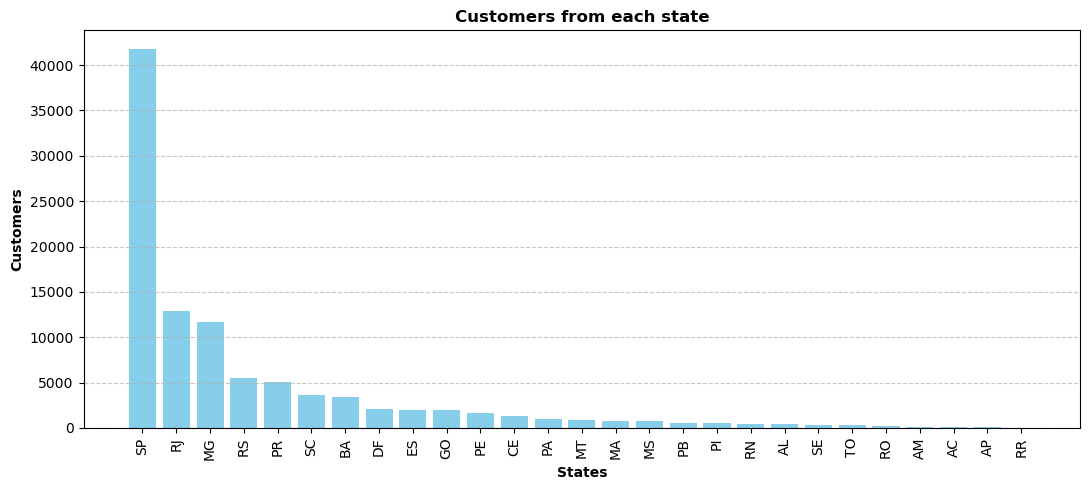

In [60]:
query = """select customer_state , count(customer_id) from customers group by customer_state order by count(customer_id) desc ;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['states','customers'])
plt.figure(figsize = (11,5))
plt.bar(df['states'], df['customers'],color = 'skyblue')
plt.xticks(rotation = 90)
# Add axis labels and title (optional)
plt.xlabel('States', weight='bold')
plt.ylabel('Customers', weight='bold')
plt.title('Customers from each state', weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6 Calculate the number of orders per month in 2018.

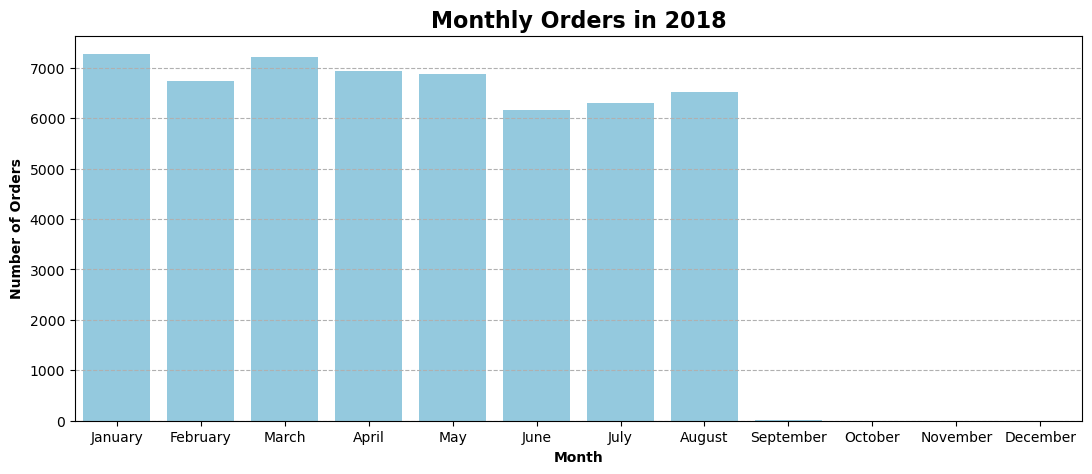

In [61]:
query = """select monthname(order_purchase_timestamp) Months, count(order_purchase_timestamp) orders from orders where year(order_purchase_timestamp) = 2018 group by Months order by Months;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['months','orders'])
order = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
plt.figure(figsize = (13,5) )
sns.barplot(x=df['months'],y=df['orders'],data = df ,order = order,color = 'skyblue')
plt.title('Monthly Orders in 2018', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=10, weight='bold')
plt.ylabel('Number of Orders', fontsize=10, weight='bold')
plt.grid(axis = 'y' , linestyle = '--')
plt.show()

# 7.Find the average number of products per order, grouped by customer city.

In [4]:
query = """with count_per_order as (
  select 
    orders.order_id,
    orders.customer_id,
    count(order_items.order_id) as oc
  from orders 
  join order_items
    on orders.order_id = order_items.order_id
  group by orders.order_id, orders.customer_id
)
select 
  customers.customer_city, 
  round(avg(count_per_order.oc), 2)
from customers 
join count_per_order 
  on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;

"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer city","Average No of Products per Order"])
df.head()


,customer city,Average No of Products per Order
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15


# 8.Calculate the percentage of total revenue contributed by each product category.

In [6]:
query = """select products.product_category category, round(sum(payments.payment_value) / (select sum(payments.payment_value) from payments) *100,2) from products 
join order_items on products.product_id = order_items.product_id
join payments on order_items.order_id = payments.order_id
group by category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","percentage"])
df.head()

,category,percentage
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,Fashion Bags and Accessories,1.36
4,bed table bath,10.70


# 9.  Identify the correlation between product price and the number of times a product has been purchased.

In [12]:

query = """select products.product_category , count(order_items.product_id),round(avg(order_items.price),2) 
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Products','counts','average price'])
a1 = df['counts']
a2 = df['average price']
np.corrcoef([a1,a2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 10 . Calculate the total revenue generated by each seller, and rank them by revenue.

In [6]:
query = """select * , dense_rank() over(order by total_revenue desc) from (select distinct sellers.seller_id seller_id, round(sum(payments.payment_value) over(partition by seller_id),2) as total_revenue 
from sellers join order_items on sellers.seller_id = order_items.seller_id
join payments on order_items.order_id = payments.order_id) a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['sellers','revenue','rank'])
df.head()

,sellers,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# 11. Calculate the moving average of order values for each customer over their order history.

In [5]:
query = """select customer_id , order_purchase_timestamp , payment , 
avg(payment) over(partition by customer_id ORDER BY order_purchase_timestamp 
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) from
(select orders.customer_id , orders.order_purchase_timestamp,payments.payment_value payment
from orders join payments on orders.order_id = payments.order_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer ID','History','Payment','Moving Average'])
df.head(10)

,Customer ID,History,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 12 . Calculate the cumulative sales per month for each year.

In [7]:
query = """select years , months ,sales , sum(sales) over(order by years, months) from
(select year(orders.order_purchase_timestamp) years, month(orders.order_purchase_timestamp) months,
round(sum(payments.payment_value),2) sales from orders
join payments on orders.order_id = payments.order_id 
group by years, months
order by years , months) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Years','Months','Sales','Cumulative Sales'])
df

,Years,Months,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [8]:
query = """select years , round(sales,2) , round(((sales - lag(sales) over(order by years)) / lag(sales) over(order by years)) * 100,3) from
(select year(orders.order_purchase_timestamp) years, sum(payments.payment_value) sales
from orders join payments on orders.order_id = payments.order_id
group by years
order by years) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Years','Sales','Growth in %'])
df

,Years,Sales,Growth in %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.704
2,2018,8699763.05,20.001


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [16]:
query = """WITH first_orders AS (
  SELECT
    customer_id,
    MIN(order_purchase_timestamp) AS first_purchase_date
  FROM orders
  GROUP BY customer_id
),

subsequent_orders AS (
  SELECT
    o.customer_id,
    f.first_purchase_date,
    o.order_purchase_timestamp
  FROM orders o
  JOIN first_orders f
    ON o.customer_id = f.customer_id
  WHERE o.order_purchase_timestamp > f.first_purchase_date
    AND o.order_purchase_timestamp <= DATE_ADD(f.first_purchase_date, INTERVAL 6 MONTH)
),

retained_customers AS (
  SELECT DISTINCT customer_id FROM subsequent_orders
)

SELECT
  ROUND(COUNT(retained.customer_id) * 100.0 / COUNT(DISTINCT first_orders.customer_id), 2) AS retention_rate_percentage
FROM first_orders
LEFT JOIN retained_customers retained
  ON first_orders.customer_id = retained.customer_id;
"""
cur.execute(query)
data = cur.fetchall()
print("Because there is not a single customer in my data who has made another purchase within 6 months of their first purchase "
", therefore the Calculated retention rate of customers is :- ", float(data[0][0]))

Because there is not a single customer in my data who has made another purchase within 6 months of their first purchase , therefore the Calculated retention rate of customers is :-  0.0


# 15. Identify the top 3 customers who spent the most money in each year.

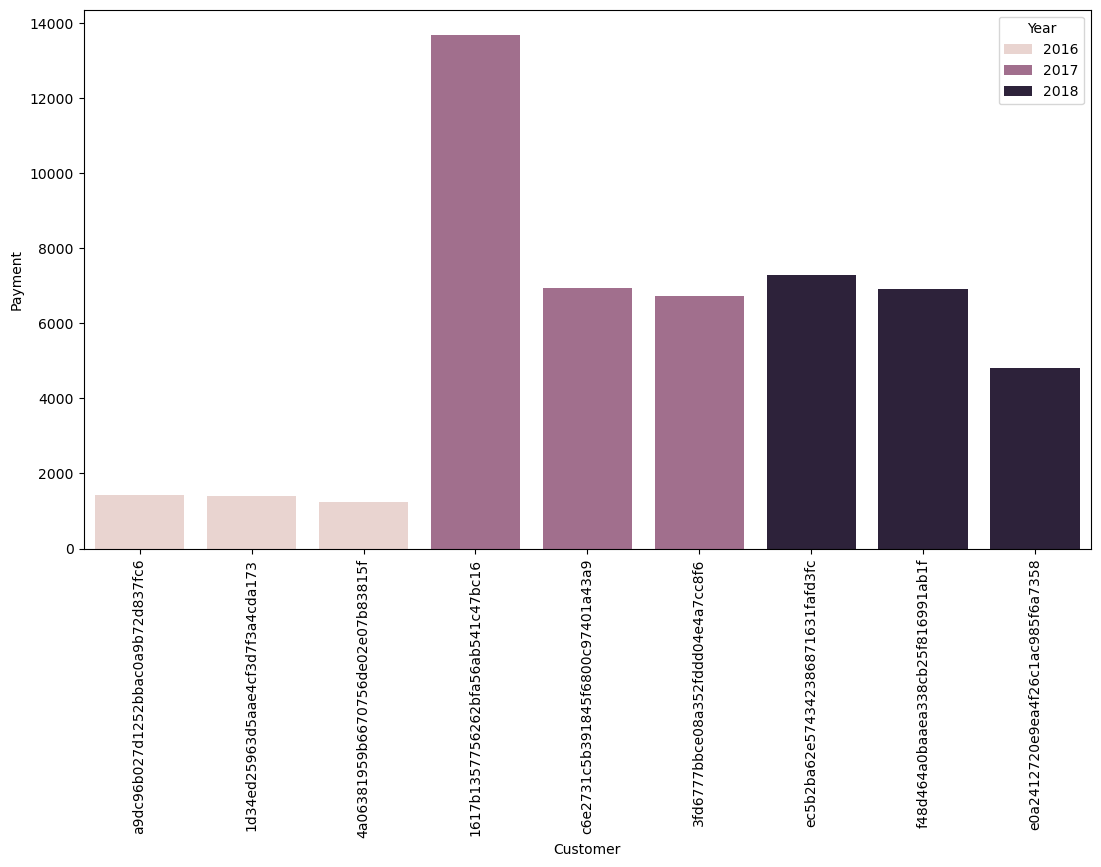

In [11]:
query = """select years ,customer , payment , ranks from 
(select year(orders.order_purchase_timestamp) years , orders.customer_id customer, sum(payments.payment_value) payment
,dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) ranks
from orders join payments on orders.order_id = payments.order_id
group by  year(orders.order_purchase_timestamp),orders.customer_id ) as a
where ranks <=3;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year','Customer','Payment','Rank'])
plt.figure(figsize = (13,7))
sns.barplot(x = df['Customer'] , y = df['Payment'],data=df,hue = df['Year'])
plt.xticks(rotation = 90)
plt.show()